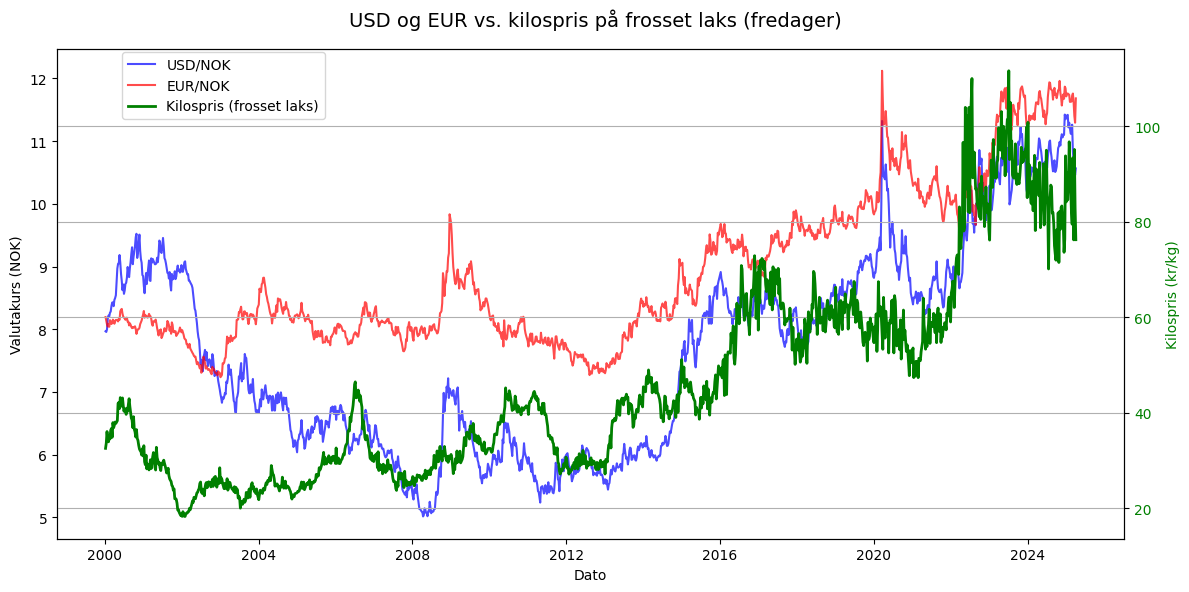


KORRELASJONER (frosset laks):
EUR/NOK og kilospris: 0.8691817958940623
USD/NOK og kilospris: 0.7444588740765478


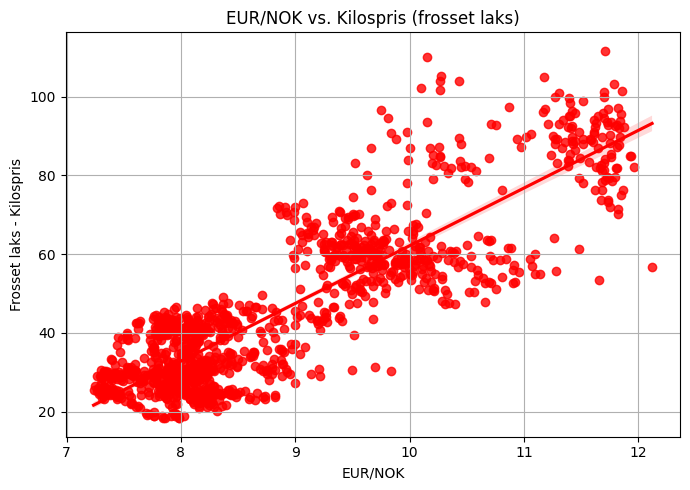

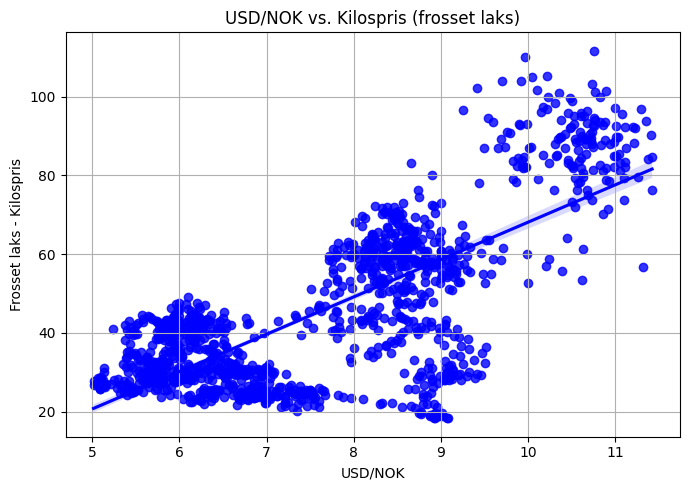

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Henter valutakurs (kun fredager)
def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]

# 2. Henter eksportdata (SSB tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 3. Analyse – for frosset laks
def analyser_frosset_laks():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()

    # Sammenstilling
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Frosset laks - Kilospris"]], on="UkeID")
    df = df.dropna()

    # ---------- 1: Plot ----------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df["Dato"], df["USD/NOK"], label="USD/NOK", color="blue", alpha=0.7)
    ax1.plot(df["Dato"], df["EUR/NOK"], label="EUR/NOK", color="red", alpha=0.7)
    ax1.set_ylabel("Valutakurs (NOK)")
    ax1.set_xlabel("Dato")

    ax2 = ax1.twinx()
    ax2.plot(df["Dato"], df["Frosset laks - Kilospris"], label="Kilospris (frosset laks)", color="green", linewidth=2)
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle("USD og EUR vs. kilospris på frosset laks (fredager)", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- 2: Korrelasjoner ----------
    print("\nKORRELASJONER (frosset laks):")
    print("EUR/NOK og kilospris:", df["EUR/NOK"].corr(df["Frosset laks - Kilospris"]))
    print("USD/NOK og kilospris:", df["USD/NOK"].corr(df["Frosset laks - Kilospris"]))

    # ---------- 3: Scatterplots ----------
    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="EUR/NOK", y="Frosset laks - Kilospris", color="red")
    plt.title("EUR/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="USD/NOK", y="Frosset laks - Kilospris", color="blue")
    plt.title("USD/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Kjør
if __name__ == "__main__":
    analyser_frosset_laks()